<a href="https://colab.research.google.com/github/San-Maansson/Stock_Analysis/blob/main/ML_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as web
import datetime as dt

In [32]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [33]:
# Load Data
company = "INTC"
start = dt.datetime(2012,1,1)
end = dt.datetime(2020,5,1)

data = web.download(company, start, end)

data.tail(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-17,62.020000,62.130001,59.830002,60.360001,54.819431,27385600
2020-04-20,59.279999,60.040001,58.889999,59.180000,53.747749,26420300
2020-04-21,58.110001,58.599998,55.930000,56.360001,51.186600,25248000
2020-04-22,58.270000,60.500000,57.810001,60.099998,54.583294,23350400
2020-04-23,59.669998,60.099998,58.810001,59.040001,53.620598,35092000
2020-04-24,56.200001,59.400002,56.099998,59.259998,53.820400,50187000
2020-04-27,59.720001,59.830002,58.389999,59.470001,54.011127,25902200
2020-04-28,59.990002,60.220001,58.259998,58.750000,53.357216,28784700
2020-04-29,59.439999,62.029999,59.320000,61.799999,56.127251,30451500


In [34]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [35]:
# Build The Model
model =Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)


Epoch 1/25
64/64 [==============================] - 9s 66ms/step - loss: 0.0124
Epoch 2/25
64/64 [==============================] - 5s 73ms/step - loss: 0.0040
Epoch 3/25
64/64 [==============================] - 4s 66ms/step - loss: 0.0030
Epoch 4/25
64/64 [==============================] - 4s 66ms/step - loss: 0.0027
Epoch 5/25
64/64 [==============================] - 5s 76ms/step - loss: 0.0025
Epoch 6/25
64/64 [==============================] - 4s 66ms/step - loss: 0.0024
Epoch 7/25
64/64 [==============================] - 4s 66ms/step - loss: 0.0022
Epoch 8/25
64/64 [==============================] - 5s 74ms/step - loss: 0.0023
Epoch 9/25
64/64 [==============================] - 4s 65ms/step - loss: 0.0022
Epoch 10/25
64/64 [==============================] - 5s 71ms/step - loss: 0.0022
Epoch 11/25
64/64 [==============================] - 4s 68ms/step - loss: 0.0019
Epoch 12/25
64/64 [==============================] - 4s 65ms/step - loss: 0.0019
Epoch 13/25
64/64 [==================

In [36]:
''' Test The Model Accuracy on Existing Data '''

# Load Test Data
test_start = dt.datetime(2020,6,1)
test_end = dt.datetime.now()

test_data = web.download(company, test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

# Make Predictions on Test Data

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)




[*********************100%***********************]  1 of 1 completed
24/24 [==============================] - 1s 17ms/step


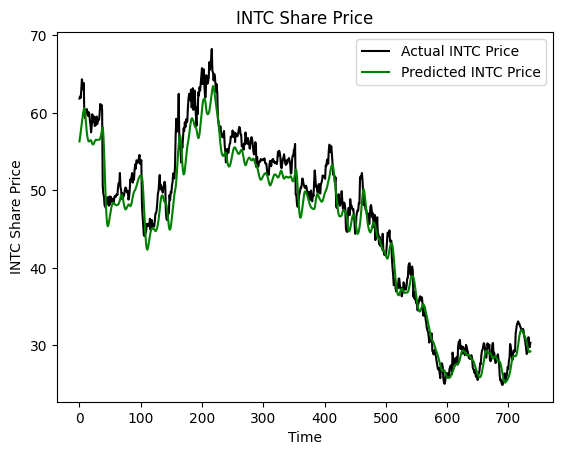

In [37]:
# Plot The Test Predictions
plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show()

In [41]:
# Predict Netxt Day
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

print(scaler.inverse_transform(real_data[-1]))

[[28.23999977]
 [27.72999954]
 [27.79999924]
 [28.54999924]
 [28.63999939]
 [28.85000038]
 [28.20000076]
 [27.61000061]
 [26.05999947]
 [25.46999931]
 [25.61000061]
 [25.13999939]
 [24.89999962]
 [24.93000031]
 [25.32999992]
 [26.20000076]
 [26.39999962]
 [25.98999977]
 [25.53000069]
 [25.97999954]
 [26.44000053]
 [27.21999931]
 [26.95000076]
 [28.01000023]
 [28.40999985]
 [30.18000031]
 [29.80999947]
 [29.15999985]
 [28.45999908]
 [28.12999916]
 [29.03000069]
 [29.36000061]
 [29.18000031]
 [29.29000092]
 [31.52000046]
 [32.09000015]
 [32.66999817]
 [32.88999939]
 [33.09999847]
 [32.83000183]
 [32.81000137]
 [32.52000046]
 [32.34999847]
 [32.02000046]
 [32.13000107]
 [31.88999939]
 [32.13999939]
 [31.82999992]
 [31.14999962]
 [30.86000061]
 [30.29999924]
 [29.65999985]
 [28.87999916]
 [29.04999924]
 [29.86000061]
 [31.05999947]
 [30.29999924]
 [29.77000046]
 [30.34499931]]


In [42]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

1/1 [==============================] - 0s 32ms/step
Prediction: [[29.318386]]
